# Train Models to Recognize Kitharai
*Adapted from the [Keras Applications](https://keras.io/api/applications/) page and [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification).*

In [1]:
# import libraries from tensorflow keras (for model building), sklearn (for metrics), matplotlib (for visualization), and np/os/pd (for data processing)
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models, applications, layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Set up the training / testing datasets

In [3]:
# create alternate absolute paths for a pre-split training / testing dataset
data_dir_train60 = os.path.dirname(os.getcwd()) + '\\data\\images-model\\train60\\'
data_dir_val20 = os.path.dirname(os.getcwd()) + '\\data\\images-model\\validate20\\'
data_dir_test20 = os.path.dirname(os.getcwd()) + '\\data\\images-model\\test20\\'

# show the paths created
# print(data_dir)
# print(data_dir_train)
# print(data_dir_test)

In [4]:
# set variables for the model here
# number of images per batch
batch_size = 32

# all images have been resized to 558x558 pixels, the median size of a kithara in the dataset
img_height = 558
img_width = 558

#### Option 2: Use the train/test split from notebook 02
*Note that `shuffle = True` [by default](https://stackoverflow.com/questions/62166588/how-to-obtain-filenames-during-prediction-while-using-tf-keras-preprocessing-ima). Explicitly set `shuffle = False` for the validation dataset in order to ensure alignment across the labels and file names (see [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)).*

In [5]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train60_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train60,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical')

# create a testing dataset from the pre-processed images
test20_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test20,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels = 'inferred',
    shuffle = False, # make sure that the 
    label_mode = 'categorical')

# create a testing dataset from the pre-processed images
val20_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val20,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels = 'inferred',
    shuffle = False, # make sure that the 
    label_mode = 'categorical')

Found 3246 files belonging to 2 classes.
Found 1082 files belonging to 2 classes.
Found 1082 files belonging to 2 classes.


In [6]:
# create an image data generator for the training and testing images
train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [7]:
# create a training and testing dataset from the pre-processed images
# this code uses the train/test split already specified in notebook 02
train_gen = train_datagen.flow_from_directory(
    data_dir_train60,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42)

# create a validation dataset from the pre-processed images
val_gen = test_datagen.flow_from_directory(
    data_dir_val20,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 42)

# create a testing dataset from the pre-processed images
test_gen = test_datagen.flow_from_directory(
    data_dir_test20,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    seed = 42)

Found 3246 images belonging to 2 classes.
Found 1082 images belonging to 2 classes.
Found 1082 images belonging to 2 classes.


#### Get some identifying information about the 

In [8]:
# create a variable to store the filepaths for the files in the val_ds dataframe
# we'll need this later to align the image IDs with the predictions
filepaths = val20_ds.file_paths
filepaths_test = test20_ds.file_paths
# check the filepaths list created
# filepaths

In [9]:
# # DO NOT USE THIS TO GET THE ACTUAL KITHARA / NO-KITHARA LABELS FOR THE IMAGES
# # STILL NEED TO DETERMINE WHY THE ARRAY CHANGES ORDER EVERY TIME IT IS RUN
val_labels = [np.argmax(y.numpy(), axis = -1) for _, y in val20_ds]
print(val_labels)
val_labels = np.concatenate(val_labels)
print(val_labels)
print(len(val_labels))

test_labels = [np.argmax(y.numpy(), axis = -1) for _, y in test20_ds]
print(test_labels)
test_labels = np.concatenate(test_labels)
print(test_labels)
print(len(test_labels))

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),

In [10]:
# check that the class names are as anticipated
class_names = train60_ds.class_names
print(class_names)

['kithara', 'no-kithara']


In [11]:
# check the batch shapes in the training dataset
for image_batch, labels_batch in train60_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 558, 558, 3)
(32, 2)


*Note that the following cell is intended to improve the performance of the model and overall memory / CPU usage, in line with the [Keras Performance Recommendations](https://www.tensorflow.org/datasets/performances).*

### Build a base model from the inceptionv3 model architecture

In [12]:
# create the base pre-trained model
# note that if this does not run, downgrade h5py
# pip install "h5py==2.10.0" --force-reinstall
base_model = applications.InceptionV3(weights = 'imagenet',
                                      include_top=False,
                                      input_shape = (img_height, img_width, 3))

### Add customizations to the base model for model01

In [13]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and add a logistic layer -- output should be the number of classes (in this case, 2)
predictions = Dense(2, activation='softmax')(x)

In [14]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics = ['BinaryAccuracy',
                        'FalseNegatives',
                        'FalsePositives',
                        'TrueNegatives',
                        'TruePositives',
                        'AUC',
                        'Precision',
                        'Recall'])

In [29]:
checkpoint_path = 'model_checkpoints/training_05/cp-{epoch}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create a callback that saves the model's weights after each training run
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq = 'epoch')

### Fit model01 on the normalized training data

# FIX THIS AND RUN ON TRAIN_GEN AND VAL_GEN WITH WRITE TO TRAINING 5

In [30]:
# set the number of passes over the entire dataset as the number of epochs
epochs = 15

# fit the model based on the normalized training data
# write the comparative metrics on the normalized training and testing data to history
history = model.fit(
  train_gen,
  validation_data = val_gen,
  epochs=epochs
)

Epoch 1/15
102/102 [==============================] - 561s 5s/step - loss: 0.1617 - binary_accuracy: 0.9304 - false_negatives: 226.0000 - false_positives: 226.0000 - true_negatives: 3020.0000 - true_positives: 3020.0000 - auc: 0.9789 - precision: 0.9304 - recall: 0.9304 - val_loss: 0.1176 - val_binary_accuracy: 0.9547 - val_false_negatives: 49.0000 - val_false_positives: 49.0000 - val_true_negatives: 1033.0000 - val_true_positives: 1033.0000 - val_auc: 0.9917 - val_precision: 0.9547 - val_recall: 0.9547
Epoch 2/15
102/102 [==============================] - 556s 5s/step - loss: 0.1168 - binary_accuracy: 0.9461 - false_negatives: 175.0000 - false_positives: 175.0000 - true_negatives: 3071.0000 - true_positives: 3071.0000 - auc: 0.9895 - precision: 0.9461 - recall: 0.9461 - val_loss: 0.1497 - val_binary_accuracy: 0.9205 - val_false_negatives: 86.0000 - val_false_positives: 86.0000 - val_true_negatives: 996.0000 - val_true_positives: 996.0000 - val_auc: 0.9842 - val_precision: 0.9205 - val

### Predict the probability that an image contains a kithara based on model01

In [31]:
# predict the probability of kithara / no-kithara label of the normalized_val_ds images
# N.B. COMMENT OUT THIS CELL ONCE IT HAS BEEN RUN TO PREVENT ACCIDENTALLY RE-RUNNING IT
test_predictions = model.predict(test_gen)

In [32]:
# check the min/max probabilities of predicted kithara / no-kithara labels
print(test_predictions.min(axis = 0))
print(test_predictions.max(axis = 0))

# print the names of the classes for clarity
print(class_names)

# return the array of predictions
print(test_predictions)

[2.6575002e-16 2.2972350e-05]
[0.999977 1.      ]
['kithara', 'no-kithara']
[[6.3999273e-02 9.3600076e-01]
 [2.1359305e-01 7.8640699e-01]
 [9.9732685e-01 2.6731817e-03]
 ...
 [1.2887157e-09 1.0000000e+00]
 [2.4870570e-12 1.0000000e+00]
 [8.7845139e-12 1.0000000e+00]]


In [33]:
# convert the probabilities into a binary class prediction
# adjust the threshold as needed to optimize for precision / recall
# N.B. the threshold is set based on probability of a `no-kithara` label
predicted_class = (test_predictions[:,1]>=0.95).astype(int)
print(predicted_class)

[0 0 0 ... 1 1 1]


### Model01 performance analysis
*Performance analysis for model01, a 10-epoch inceptionv3 instance with two additional layers trained on images that have only been normalized to 0-1 as opposed to 0-255 per pixel value.*

In [34]:
# take a look at the metrics from each epoch
history.history

{'loss': [0.16172060370445251,
  0.11681834608316422,
  0.10315106064081192,
  0.0931943729519844,
  0.08982505649328232,
  0.07851969450712204,
  0.07552241533994675,
  0.07512472569942474,
  0.07153346389532089,
  0.06759466230869293,
  0.06980705261230469,
  0.05679675564169884,
  0.05856212228536606,
  0.05952170491218567,
  0.05888190120458603],
 'binary_accuracy': [0.930375874042511,
  0.9460874795913696,
  0.9550215601921082,
  0.9593345522880554,
  0.961491048336029,
  0.9707332253456116,
  0.9704251289367676,
  0.9704251289367676,
  0.9710412621498108,
  0.9735058546066284,
  0.9725816249847412,
  0.9805914759635925,
  0.9735058546066284,
  0.9781269431114197,
  0.9775108098983765],
 'false_negatives': [226.0,
  175.0,
  146.0,
  132.0,
  125.0,
  95.0,
  96.0,
  96.0,
  94.0,
  86.0,
  89.0,
  63.0,
  86.0,
  71.0,
  73.0],
 'false_positives': [226.0,
  175.0,
  146.0,
  132.0,
  125.0,
  95.0,
  96.0,
  96.0,
  94.0,
  86.0,
  89.0,
  63.0,
  86.0,
  71.0,
  73.0],
 'true_ne

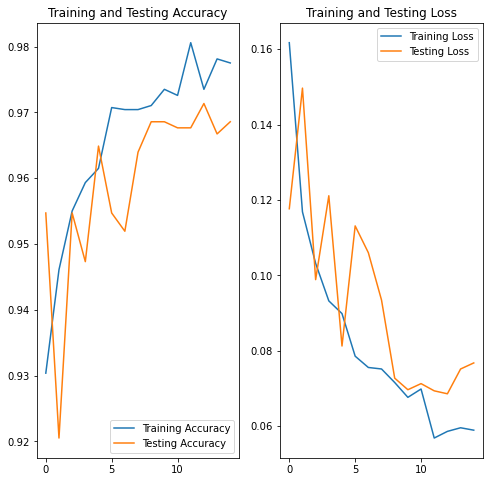

In [35]:
# visualize the model's performance epoch-by-epoch

# set accuracy variables
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# set loss variables
loss = history.history['loss']
val_loss = history.history['val_loss']

# set epoch range
epochs_range = range(epochs)

# plot accuracy for training vs. testing dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

# plot loss for training vs. testing dataset
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

In [36]:
# print the accuracy of the kithara identification compared to the predicted class with the threshold set above
print(accuracy_score(test_labels, predicted_class))

# print the AUC for the model
print(roc_auc_score(test_labels, test_predictions[:,1]))

# print the overall classification report with precision, recall, accuracy, and f1-scores
print(classification_report(test_labels, predicted_class, target_names = class_names))

0.977818853974122
0.9945365853658537
              precision    recall  f1-score   support

     kithara       0.82      0.90      0.86        82
  no-kithara       0.99      0.98      0.99      1000

    accuracy                           0.98      1082
   macro avg       0.91      0.94      0.92      1082
weighted avg       0.98      0.98      0.98      1082



In [37]:
# create a dataframe to hold the filenames, actual values, and predicted no-kithara probability
pred_df = pd.DataFrame({'filepath': filepaths_test, 'actuals': test_labels, 'predictions': test_predictions[:,0]})

# take a look at the dataframe where the known value was a kithara
pred_df[pred_df['actuals'] == 0].sort_values('predictions')

,filepath,actuals,predictions
23,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG1400b-kithara-full.jpg,0,0.000087
34,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG2027-kithara-full.jpg,0,0.000386
14,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG0366-kithara-full.jpg,0,0.000508
3,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG0077-kithara-full.jpg,0,0.001195
11,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG0310-kithara-full.jpg,0,0.003472
30,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG1846a-kithara-full.jpg,0,0.016629
17,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG0745-kithara-full.jpg,0,0.034209
77,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG9871b-kithara-full.jpg,0,0.045856
0,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG0009-kithara-full.jpg,0,0.063999
76,C:\Tomrec\Catalogue_Images\_vision\ds4-cv-vases\data\images-model\test20\kithara\IMAG9870a-kithara-full.jpg,0,0.078286


In [ ]:
# # check to see if specific images are included in the training dataset
# pred_df01[pred_df01['filepath'].str.contains('IMAG9081')]

### To train on more layers:

In [ ]:
# look at the inceptionv3 layer names and layer indices to see how many layers the base model has
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')